# Plot data
- Plots log-transformed linear as well as exponential model
- Evalutates dataset for normality and heteroscedasticity
- Also plots electropherogram data for high-resolution, publication-worthy image

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.stats import linregress, shapiro
from scipy import stats
from scipy.interpolate import make_interp_spline
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.graphics.gofplots as sm_gof

In [3]:
fs_data=pd.read_csv("fs_summary.csv")

In [4]:
fs_data.head(5)

,sample,n_rep,rf_mean,conc_mean,s_x,CI_low,CI_high,n_add
0,FS-15N-1,3,1.894745,0.429943,0.032616,0.362302,0.497584,3.75
1,FS-15N-2,3,1.496906,0.338468,0.032737,0.270575,0.406361,3.75
2,FS-15N-3,3,3.035858,0.692320,0.032417,0.625091,0.759548,3.75
3,FS-15N-4,3,8.154848,1.869330,0.034238,1.798324,1.940336,3.75
4,FS-15N-5,3,3.852337,0.880053,0.032412,0.812834,0.947272,3.75


## Log-transformed linear model

/tmp/ipykernel_37392/809442293.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_fit,y_fit, 'r-', label=f'Fit: y={slope:.6g}*x + {intercept:.6g}, r2={r**2}',color='black')


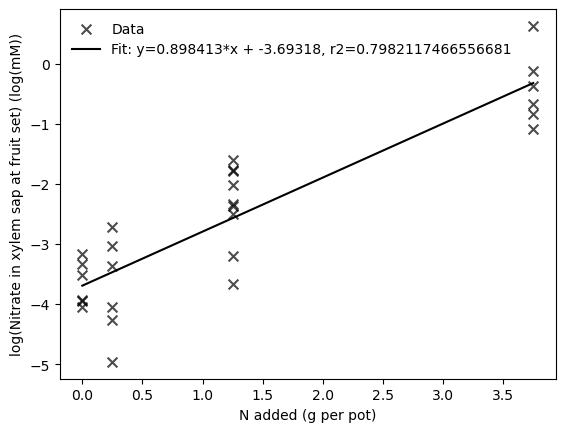

In [45]:
x=fs_data['n_add']
y=np.log(fs_data['conc_mean'])

slope,intercept,r,p,stderr=linregress(x,y)

x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = intercept + slope * x_fit

plt.scatter(x, y, s=50, alpha=0.7, label='Data',marker='x',color='black')
plt.plot(x_fit,y_fit, 'r-', label=f'Fit: y={slope:.6g}*x + {intercept:.6g}, r2={r**2}',color='black')
plt.xlabel("N added (g per pot)")
plt.ylabel("log(Nitrate in xylem sap at fruit set) (log(mM))")
plt.legend(frameon=False)
plt.savefig("fruitset-linear.svg", format="svg", bbox_inches="tight")
plt.savefig("fruitset-linear.tiff",format="tiff",bbox_inches="tight",dpi=300)
plt.show()

## Statistical tests
- Shapiro-Wilks for normality
- Breusch-Pagan for heteroscedasticity

In [8]:
#Redo linear model
x=fs_data['n_add']
y=np.log(fs_data['conc_mean'])

slope,intercept,r,p,stderr=linregress(x,y)

#Calculate residuals
y_pred=intercept+slope*x
residuals=y-y_pred

#Shapiro-Wilks 
shapiro_stat,shapiro_p_value=shapiro(residuals)

#Breusch-Pagan
X=sm.add_constant(x)
bp_stat,bp_p_value,_,_=het_breuschpagan(residuals,X)

print(f"Shapiro-Wilks Test: statistic={shapiro_stat:.4f},p-value={shapiro_p_value:.4f}")
print(f"Breusch-Pagan test: statistic={bp_stat:.4f},p-value={bp_p_value:.4f}")

Shapiro-Wilks Test: statistic=0.9698,p-value=0.5963
Breusch-Pagan test: statistic=0.0339,p-value=0.8540


## Evaluate model
- Q-Q plot to evaluate residuals

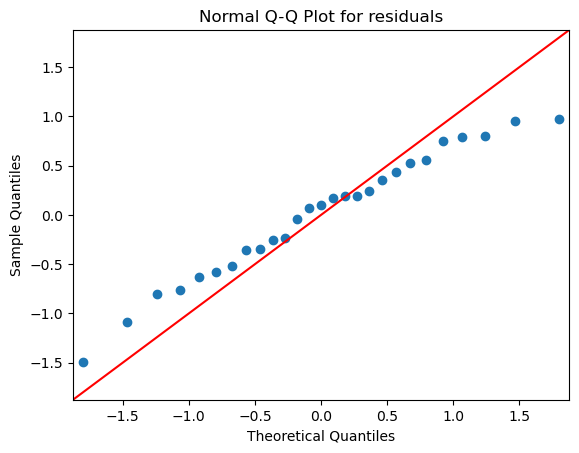

In [10]:
#Plot residuals vs "ideal" residuals to get an idea of what they look like
sm.qqplot(residuals,line='45') #'45' = ideal
plt.title("Normal Q-Q Plot for residuals")
plt.savefig("linear-qqplot.svg", format="svg", bbox_inches="tight")
plt.savefig("linear-qqplot.tiff",format="tiff",bbox_inches="tight",dpi=300)
plt.show()

In [11]:
#These strongly suggest that the assumptions of normality and homoscedasticity cannot be rejected
#Power here is pretty low due to low number of observations, but evidence is still pretty strong

## Exponential model
- We'll also plot the exponential model just to see how it looks
- Statistical analyses would need adjusting to account for non-linear relationship (B-P assumes linearity)

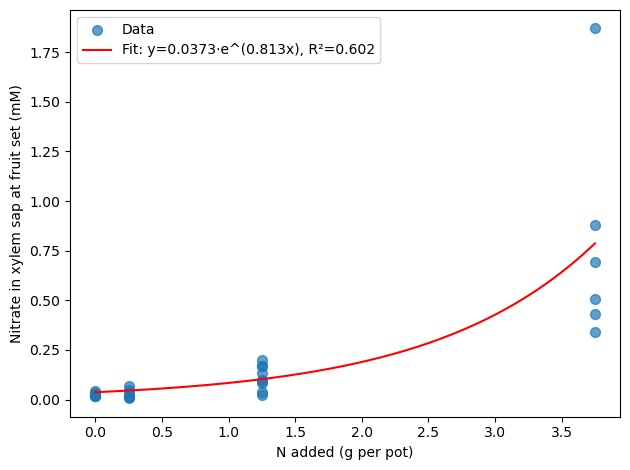

In [13]:
# define exponential model
def expo(x, a, b):
    return a * np.exp(b * x)

# filter to positive concentrations (log undefined for ≤0, and exp fits need >0)
mask = fs_data['conc_mean'] > 0
x = fs_data.loc[mask, 'n_add'].to_numpy()
y = fs_data.loc[mask, 'conc_mean'].to_numpy()

# initial guesses for parameters to help the optimizer
p0 = (y.min(), 0.05)

# fit exponential curve
popt, pcov = curve_fit(expo, x, y, p0=p0)
a, b = popt

# generate smooth x-values for the fitted curve
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = expo(x_fit, a, b)

residuals = y - expo(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res / ss_tot)

# plot data and fit
plt.scatter(x, y, s=50, alpha=0.7, label='Data')
plt.plot(x_fit, y_fit, 'r-', label=f'Fit: y={a:.3g}·e^({b:.3g}x), R²={r2:.3f}')
plt.xlabel("N added (g per pot)")
plt.ylabel("Nitrate in xylem sap at fruit set (mM)")
plt.legend()
plt.tight_layout()
plt.savefig("fruitset-exponential.svg", format="svg", bbox_inches="tight")
plt.savefig("fruitset-exponential.tiff",format="tiff",bbox_inches="tight",dpi=300)
plt.show()

## High resolution electropherogram
- CE-UV-vis data were exported directly from Agilent MassHunter to .csv
- Requires data files in `01-input_data` directory

In [15]:
#Read CSVs
std=pd.read_csv("../01-input_data/nitrite_nitrate_TFA.CSV",header=None,sep=',')
samp=pd.read_csv("../01-input_data/V-15N-5-r001.CSV",header=None,sep=',')

In [16]:
print(std)

                        0           1                           2
0    #"CEDAD1 - A:Sig=200  4  Ref=360  100 nitrite_nitrate_TFA.d"
1                  #Point  X(Minutes)           Y(Response Units)
2                       0       0.004         -0.0300407409667969
3                       1       0.010         -0.0348091125488281
4                       2       0.017         -0.0391006469726563
..                    ...         ...                         ...
597                   595       3.970          -0.205516815185547
598                   596       3.977          -0.205039978027344
599                   597       3.984          -0.202655792236328
600                   598       3.990          -0.197410583496094
601                   599       3.997          -0.188827514648438

[602 rows x 3 columns]


In [17]:
#Of course Agilent exports non-standard CSVs
std=std.iloc[1:]
samp=samp.iloc[1:]
print(std)

          0           1                    2
1    #Point  X(Minutes)    Y(Response Units)
2         0       0.004  -0.0300407409667969
3         1       0.010  -0.0348091125488281
4         2       0.017  -0.0391006469726563
5         3       0.024  -0.0424385070800781
..      ...         ...                  ...
597     595       3.970   -0.205516815185547
598     596       3.977   -0.205039978027344
599     597       3.984   -0.202655792236328
600     598       3.990   -0.197410583496094
601     599       3.997   -0.188827514648438

[601 rows x 3 columns]


In [18]:
print(std[1])
print(std[1].iloc[1:])

1      X(Minutes)
2           0.004
3           0.010
4           0.017
5           0.024
          ...    
597         3.970
598         3.977
599         3.984
600         3.990
601         3.997
Name: 1, Length: 601, dtype: object
2      0.004
3      0.010
4      0.017
5      0.024
6      0.030
       ...  
597    3.970
598    3.977
599    3.984
600    3.990
601    3.997
Name: 1, Length: 600, dtype: object


In [19]:
#We'll just address the columns directly

#Need x and y values for plotting
#CSV was encoding as strings instead of numbers for some ungodly reason
std_x=std[1].iloc[1:].values.astype(float)
std_y=std[2].iloc[1:].values.astype(float)

samp_x=samp[1].iloc[1:].values.astype(float)
samp_y=samp[2].iloc[1:].values.astype(float)

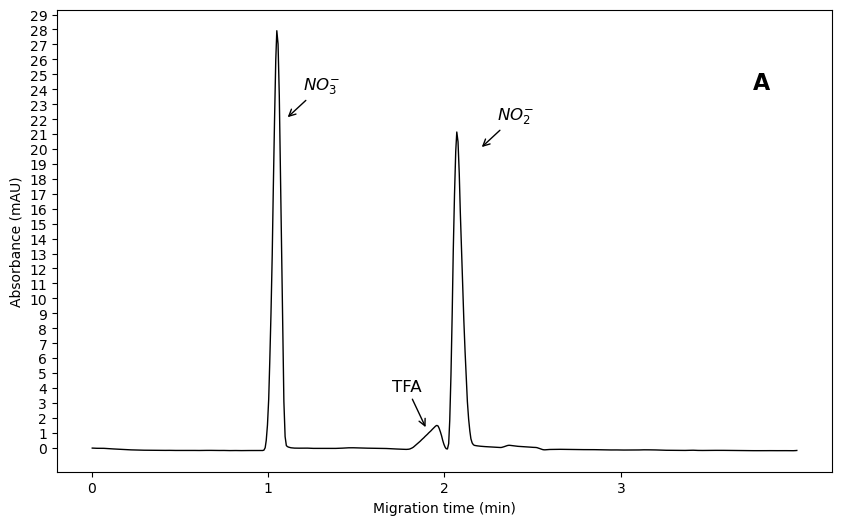

In [20]:
#Start with plot of standards

plt.figure(figsize=(10,6))
plt.plot(std_x,std_y,color='black',linewidth=1)
plt.xticks(range(0,4))
plt.yticks(range(0,30))
plt.xlabel("Migration time (min)")
plt.ylabel("Absorbance (mAU)")
plt.text(3.75,24,"A",weight='bold',fontsize=16)
plt.annotate(r'$NO_{3}^{-}$',xy=(1.1,22),xytext=(1.2,24),fontsize=12,arrowprops=dict(arrowstyle='->'))
plt.annotate(r'$NO_{2}^{-}$',xy=(2.2,20),xytext=(2.3,22),fontsize=12,arrowprops=dict(arrowstyle='->'))
plt.annotate('TFA',xy=(1.9,1.2),xytext=(1.7,3.8),fontsize=12,arrowprops=dict(arrowstyle='->'))
plt.savefig('std_trace.svg',format="svg",bbox_inches="tight")
plt.savefig('std_trace.tiff',format="tiff",bbox_inches="tight",dpi=300)
plt.show()

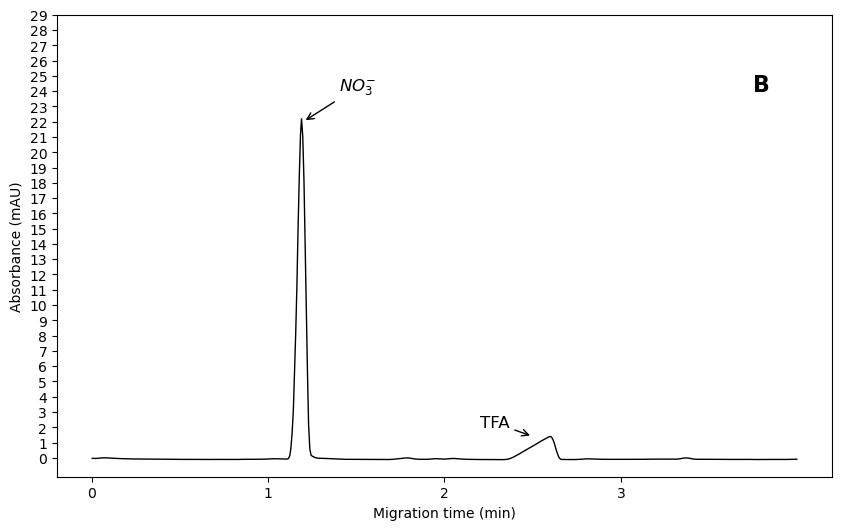

In [21]:
#Plot of sample

plt.figure(figsize=(10,6))
plt.plot(samp_x,samp_y,color='black',linewidth=1)
plt.xticks(range(0,4))
plt.yticks(range(0,30))
plt.xlabel("Migration time (min)")
plt.ylabel("Absorbance (mAU)")
plt.text(3.75,24,"B",weight='bold',fontsize=16)
plt.annotate(r'$NO_{3}^{-}$',xy=(1.2,22),xytext=(1.4,24),fontsize=12,arrowprops=dict(arrowstyle='->'))
plt.annotate('TFA',xy=(2.5,1.4),xytext=(2.2,2.0),fontsize=12,arrowprops=dict(arrowstyle='->'))
plt.savefig('samp_trace.svg',format="svg",bbox_inches="tight")
plt.savefig('samp_trace.tiff',format="tiff",bbox_inches="tight",dpi=300)
plt.show()